In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [6]:
rfModel_wind = RandomForestRegressor()
f_columns = ["season","weather","humidity","month","temp","year","hour","dayofweek","atemp"]
X_train = train[f_columns]
y_r_label = train['registered']
y_c_label = train['casual']
print(X_train.shape)
print(y_r_label.shape)
print(y_c_label.shape)

(10886, 9)
(10886,)
(10886,)


In [7]:
X_test = test[f_columns]
X_test.shape

(6493, 9)

In [8]:
rfModel = RandomForestRegressor()
rfModel.fit(X_train, y_r_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [9]:
testRegisteredValues = rfModel.predict(X_test)

In [10]:
test['registered'] = testRegisteredValues
test["registered"].isnull().sum()

0

In [11]:
rfModel.fit(X_train, y_c_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:
testCasualValues = rfModel.predict(X_test)
test['casual'] = testCasualValues
test["casual"].isnull().sum()

0

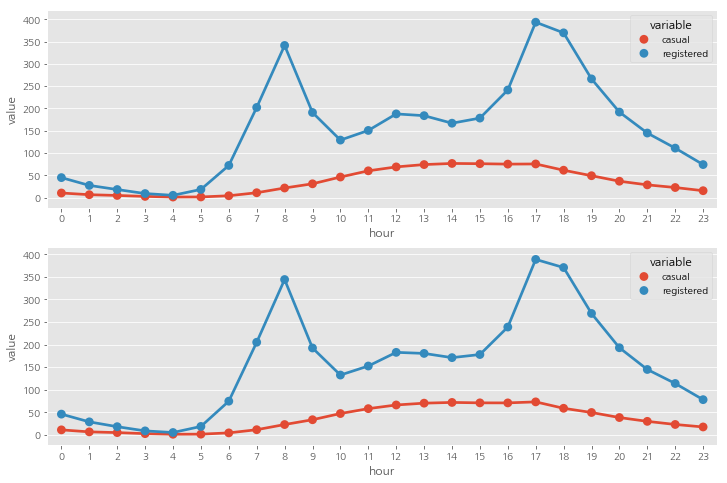

In [13]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12,8)

hourTransformed = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True, ax=ax1)


hourTransformed = pd.melt(test[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True, ax=ax2)

In [ ]:
# train과 test 데이터셋을 합쳐준다.
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [ ]:
# 풍속이 0인 데이터들의 값을 보정해 준다.

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

In [ ]:
categoricalFeatureNames = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [ ]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [ ]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]